# Presynaptic profiles analysis

---

Pre-synaptic axonal terminals with GCamp5f

In [1]:
import sys
import os
import yaml

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

from scipy import signal
from scipy import stats
from scipy import ndimage

from skimage import io

from sklearn import preprocessing

## Full frame analysis

### Data & metadata uploading

A+C_10.0 : [45.2 47.2]
C_10.0 : [82.5 84.5]
A_10.0 : [115.6 118.5]
A+C_0.1 : [151.9 251.9]
C_0.1 : [275.1 375.1]
A+C_10-150_0.1 : [422.6 572.6]


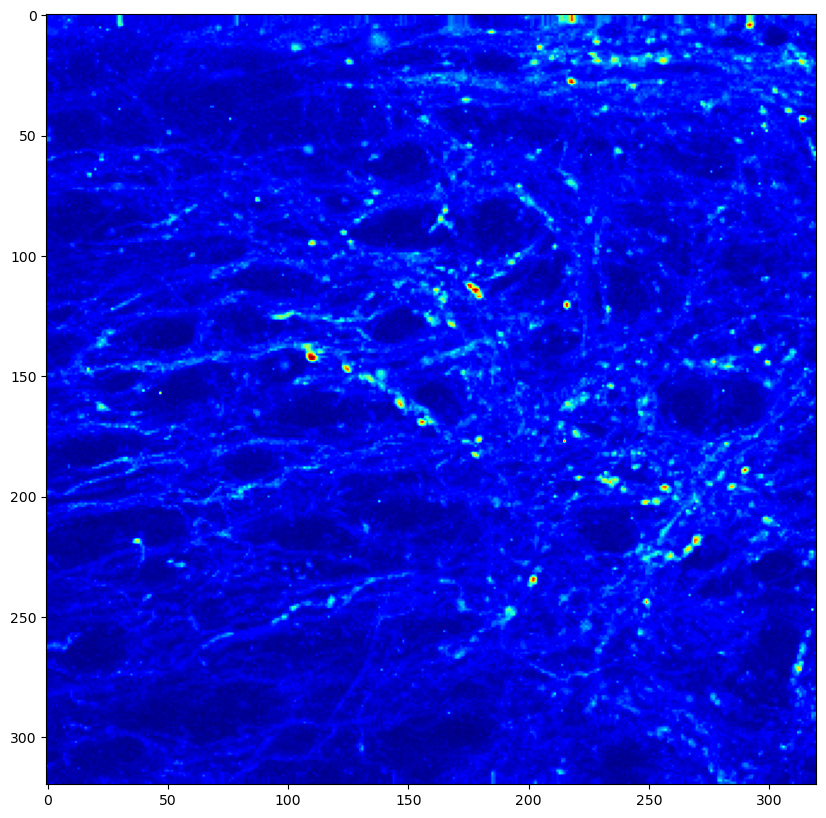

In [9]:
samp_name = 'A0005'
samp_path = os.path.join(''.join(sys.path[0].split('neuro')), 'data_neuro', samp_name)

# sample YAML metadata file uploading
with open(f'{samp_path}/{samp_name}_meta.yaml') as f:
    samp_meta = yaml.safe_load(f)

# sample img series uploading
img = io.imread(f'{samp_path}/pre_gcamp_mov_cor.tif')
plt.figure(figsize=(10,10))
plt.imshow(np.max(img, axis=0), cmap='jet')


# time parameters (from meta file)
total_reg_t = samp_meta['Reg_time']
frame_time = total_reg_t / img.shape[0]
time_line = np.linspace(0, total_reg_t, num=img.shape[0])

# treatment parameters (from meta file)
treatment_dict = {}
for samp in samp_meta['Events']:
    treat_name = f"{samp['Type']}_{samp['Freq']}"
    start_time = samp['Time']/1000
    end_time = start_time + samp['Duration']
    treatment_dict.update({treat_name:[start_time, end_time]})
for k,v in treatment_dict.items():  # app time print
    print(k, ':', np.around(v, 1))

application_lines_dict = {t:np.linspace(treatment_dict[t][0], treatment_dict[t][1]) for t in treatment_dict}


### Total profile

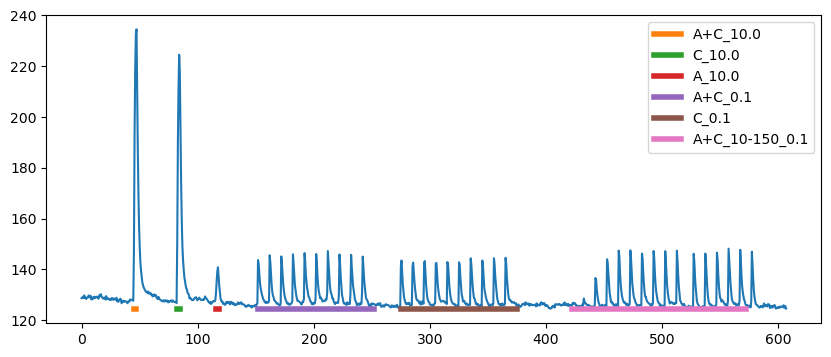

In [61]:
prof = np.asarray([np.mean(frame) for frame in img])

plt.figure(figsize=(10, 4))
plt.plot(time_line, prof)

for line_name in application_lines_dict:
        line_lim = application_lines_dict[line_name]
        plt.plot(line_lim, [np.min(prof)] * len(line_lim), label=line_name, linewidth=4)
        
plt.legend()

### 0.1 Hz stim. 150 uA

Profiles

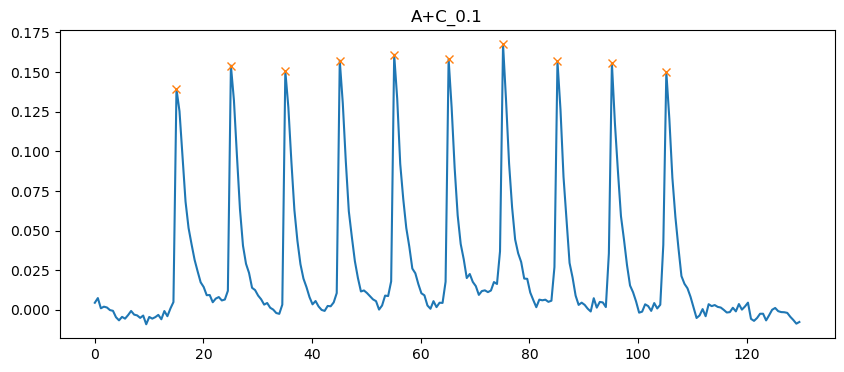

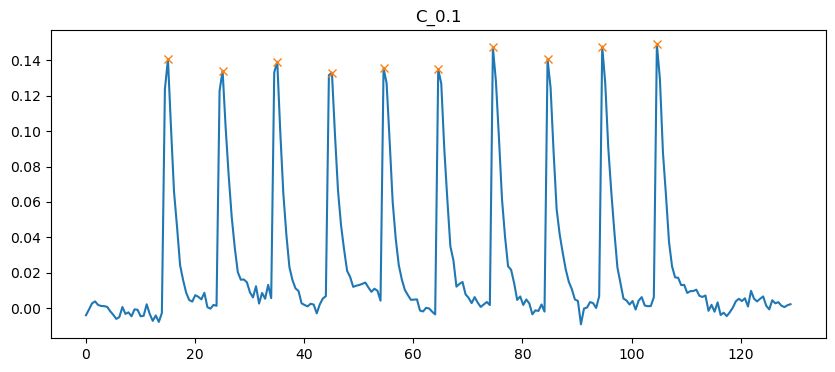

In [65]:
stim_ext_sec = 15

min_distance_sec = 8
min_distance_frames = int(min_distance_sec / frame_time)
if min_distance_frames < 1:
    min_distance_frames = 1

LF_dF_stim_prof = {}
LF_stim_df = pd.DataFrame(columns=['stim',
                                   'amp_raw',
                                   'amp_dF'])

for line_name in treatment_dict:
        if line_name in ['A+C_0.1', 'C_0.1']:
                t_lim = treatment_dict[line_name]
                time_mask = (time_line>=(t_lim[0]-stim_ext_sec)) & \
                            (time_line<=(t_lim[1]+stim_ext_sec))

                stim_prof = prof[time_mask]
                F_0 = np.mean(stim_prof[:stim_ext_sec-5])
                dF_stim_prof = (stim_prof-F_0)/F_0
                LF_dF_stim_prof.update({line_name:dF_stim_prof})

                stim_time = time_line[:len(stim_prof)]

                peaks, properties = signal.find_peaks(dF_stim_prof,
                                                      height=np.max(dF_stim_prof)*0.1,
                                                      distance=min_distance_frames)
                
                stim_df = pd.DataFrame({'stim':np.full(len(peaks), line_name),
                                        'amp_raw':stim_prof[peaks],
                                        'amp_dF':dF_stim_prof[peaks]})
                LF_stim_df = pd.concat([LF_stim_df, stim_df], ignore_index=True)

                plt.figure(figsize=(10, 4))
                plt.plot(stim_time, dF_stim_prof)
                plt.plot(stim_time[peaks], dF_stim_prof[peaks], 'x')
                plt.title(line_name)

Stat.

In [74]:
group_1 = LF_stim_df['amp_dF'][LF_stim_df['stim'] == 'A+C_0.1']
group_2 = LF_stim_df['amp_dF'][LF_stim_df['stim'] == 'C_0.1']

u_val, p_val = stats.mannwhitneyu(group_1, group_2)
print(f'U-test p-value={p_val}')

fig = px.box(LF_stim_df, x='stim' , y='amp_dF', color='stim', points="all")
fig.show()

U-test p-value=0.0007685389131627665


### 0.1 Hz 10-150 uA

Profile

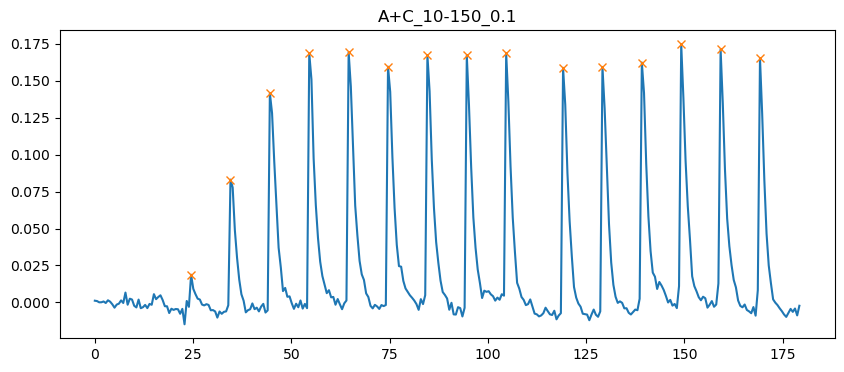

In [102]:
stim_ext_sec = 15

min_distance_sec = 8
min_distance_frames = int(min_distance_sec / frame_time)
if min_distance_frames < 1:
    min_distance_frames = 1

LF_dF_up_prof = {}
LF_up_df = pd.DataFrame(columns=['stim',
                                 'time',
                                 'amp_raw',
                                 'amp_dF',
                                 'cur'])

for line_name in treatment_dict:
        if line_name in ['A+C_10-150_0.1']:
                t_lim = treatment_dict[line_name]
                time_mask = (time_line>=(t_lim[0]-stim_ext_sec)) & \
                            (time_line<=(t_lim[1]+stim_ext_sec))

                stim_prof = prof[time_mask]
                F_0 = np.mean(stim_prof[:stim_ext_sec-5])
                dF_stim_prof = (stim_prof-F_0)/F_0
                LF_dF_up_prof.update({line_name:dF_stim_prof})

                stim_time = time_line[:len(stim_prof)]

                peaks, properties = signal.find_peaks(dF_stim_prof,
                                                      height=np.max(dF_stim_prof)*0.1,
                                                      distance=min_distance_frames)
                
                # stim_val = ['150', '140', '130', '120', '110', '100', '90', '80', '70', '60', '50', '40', '30', '20', '10']
                stim_val = range(10, 160, 10)
                stim_df = pd.DataFrame({'stim':np.full(len(peaks), line_name),
                                        'time':stim_time[peaks],
                                        'amp_raw':stim_prof[peaks],
                                        'amp_dF':dF_stim_prof[peaks,],
                                        'cur': stim_val})  # list(reversed(stim_val))
                LF_up_df = pd.concat([LF_up_df, stim_df], ignore_index=True)

                plt.figure(figsize=(10, 4))
                plt.plot(stim_time, dF_stim_prof)
                plt.plot(stim_time[peaks], dF_stim_prof[peaks], 'x')
                plt.title(line_name)

Stat.

In [86]:
fig = px.line(LF_up_df, x='cur', y='amp_dF', markers=True)
fig.show()

In [99]:
crop_up_df = LF_up_df[LF_up_df['cur'] >= 40].drop(['time', 'cur'], axis=1)
LF_total_df = pd.concat([LF_stim_df, crop_up_df], ignore_index=True)

group_0 = LF_total_df['amp_dF'][LF_total_df['stim'] == 'A+C_0.1']
group_1 = LF_total_df['amp_dF'][LF_total_df['stim'] == 'C_0.1']
group_2 = LF_total_df['amp_dF'][LF_total_df['stim'] == 'A+C_10-150_0.1']
hsd_test = stats.tukey_hsd(group_0, group_1, group_2)
print(hsd_test)

fig = px.box(LF_total_df, x='stim' , y='amp_dF', color='stim', points="all")
fig.show()

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.015     0.000     0.008     0.022
 (0 - 2)     -0.011     0.001    -0.017    -0.004
 (1 - 0)     -0.015     0.000    -0.022    -0.008
 (1 - 2)     -0.026     0.000    -0.032    -0.019
 (2 - 0)      0.011     0.001     0.004     0.017
 (2 - 1)      0.026     0.000     0.019     0.032



### 10 Hz stims. 150 uA

dict_keys(['A+C_10.0', 'C_10.0', 'A_10.0'])


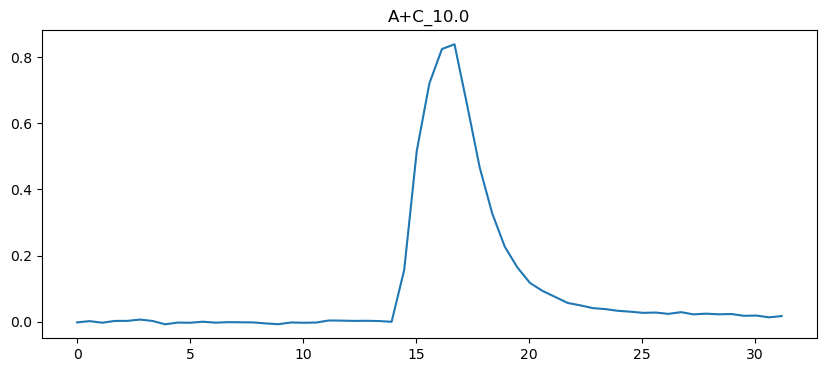

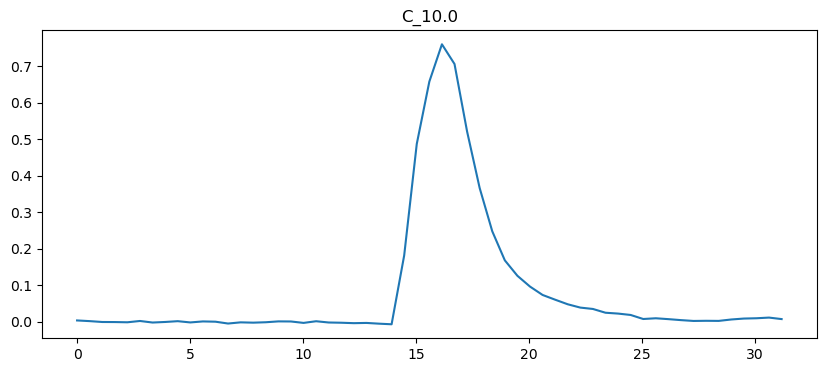

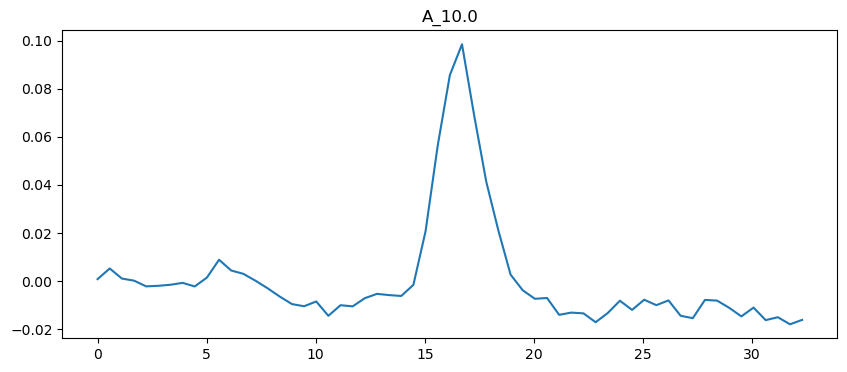

In [100]:
stim_ext_sec = 15

HF_dF_stim_prof = {}
for line_name in treatment_dict:
        if line_name.split('_')[-1] == '10.0':
                t_lim = treatment_dict[line_name]
                time_mask = (time_line>=(t_lim[0]-stim_ext_sec)) & (time_line<=(t_lim[1]+stim_ext_sec))
                
                stim_prof = prof[time_mask]
                F_0 = np.mean(stim_prof[:stim_ext_sec-5])
                dF_stim_prof = (stim_prof-F_0)/F_0

                HF_dF_stim_prof.update({line_name:dF_stim_prof})

                plt.figure(figsize=(10, 4))
                plt.plot(time_line[:len(stim_prof)], dF_stim_prof)
                plt.title(line_name)
                # plt.plot(line_lim, [np.min(prof)] * len(line_lim), label=line_name, linewidth=4)
print(HF_dF_stim_prof.keys())